In [9]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np


class Grid: # Environment
  def __init__(self, width, height, start):
    self.width = width
    self.height = height
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards should be a dict of: (i, j): r (row, col): reward
    # actions should be a dict of: (i, j): A (row, col): list of possible actions
    self.rewards = rewards
    self.actions = actions

  def set_state(self, s):
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    return (self.i, self.j)

  def is_terminal(self, s):
    return s not in self.actions

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    # return a reward (if any)
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    # these are the opposite of what U/D/L/R should normally do
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    # raise an exception if we arrive somewhere we shouldn't be
    # should never happen
    assert(self.current_state() in self.all_states())

  def game_over(self):
    # returns true if game is over, else false
    # true if we are in a state where no actions are possible
    return (self.i, self.j) not in self.actions

  def all_states(self):
    # possibly buggy but simple way to get all states
    # either a position that has possible next actions
    # or a position that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


def standard_grid():
  # define a grid that describes the reward for arriving at each state
  # and possible actions at each state
  # the grid looks like this
  # x means you can't go there
  # s means start position
  # number means reward at that state
  # .  .  .  1
  # .  x  . -1
  # s  .  .  .
  g = Grid(3, 4, (2, 0))
  rewards = {(0, 3): 1, (1, 3): -1}
  actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
  }
  g.set(rewards, actions)
  return g


def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g



MoteCarlo Prediction with only policy evaluation

In [2]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")


# NOTE: this is only policy evaluation, not optimization

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  return states_and_returns


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U',
  }

  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  # repeat
  for t in range(100):

    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
values:
---------------------------
 0.81| 0.90| 1.00| 0.00|
---------------------------
 0.73| 0.00|-1.00| 0.00|
---------------------------
 0.66|-0.81|-0.90|-1.00|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  U  |  R  |  R  |  U  |


MonteCarlo plicy evaluation with optimization

In [10]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")



def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this, because given our current deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  states_and_rewards = [(s, 0)] # list of tuples of (state, reward)
  while not grid.game_over():
    a = policy[s]
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s, r))
  # calculate the returns by working backwards from the terminal state
  G = 0
  states_and_returns = []
  first = True
  for s, r in reversed(states_and_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_and_returns.append((s, G))
    G = r + GAMMA*G
  states_and_returns.reverse() # we want it to be in order of state visited
  return states_and_returns


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  grid = standard_grid()

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'L',
  }

  # initialize V(s) and returns
  V = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions:
      returns[s] = []
    else:
      # terminal state or state we can't otherwise get to
      V[s] = 0

  # repeat
  for t in range(100):

    # generate an episode using pi
    states_and_returns = play_game(grid, policy)
    seen_states = set()
    for s, G in states_and_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      if s not in seen_states:
        returns[s].append(G)
        V[s] = np.mean(returns[s])
        seen_states.add(s)

  print("values:")
  print_values(V, grid)
  print("policy:")
  print_policy(policy, grid)


rewards:
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


KeyboardInterrupt: ignored

MonteCarlo Exploring Starts

rewards:
---------------------------
-0.90|-0.90|-0.90| 1.00|
---------------------------
-0.90| 0.00|-0.90|-1.00|
---------------------------
-0.90|-0.90|-0.90|-0.90|
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


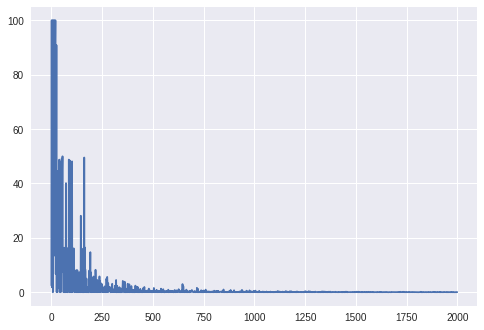

final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  R  |     |
---------------------------
  R  |  R  |  U  |  U  |
final values:
---------------------------
-1.06|-0.15| 1.00| 0.00|
---------------------------
-2.02| 0.00|-1.00| 0.00|
---------------------------
-3.17|-2.67|-1.80|-1.00|


In [4]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt


GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

# NOTE: this script implements the Monte Carlo Exploring-Starts method
#       for finding the optimal policy

def play_game(grid, policy):
  # returns a list of states and corresponding returns

  # reset game to start at a random position
  # we need to do this if we have a deterministic policy
  # we would never end up at certain states, but we still want to measure their value
  # this is called the "exploring starts" method
  start_states = list(grid.actions.keys())
  start_idx = np.random.choice(len(start_states))
  grid.set_state(start_states[start_idx])

  s = grid.current_state()
  a = np.random.choice(ALL_POSSIBLE_ACTIONS) # first action is uniformly random

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  seen_states = set()
  while True:
    old_s = grid.current_state()
    r = grid.move(a)
    s = grid.current_state()

    if s in seen_states:
      # hack so that we don't end up in an infinitely long episode
      # bumping into the wall repeatedly
      states_actions_rewards.append((s, None, -100))
      break
    elif grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = policy[s]
      states_actions_rewards.append((s, a, r))
    seen_states.add(s)

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns


def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.9)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0 # needs to be initialized to something so we can argmax it
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(2000):
    if t % 100 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # update policy
    for s in policy.keys():
      policy[s] = max_dict(Q[s])[0]

  plt.plot(deltas)
  plt.show()

  print("final policy:")
  print_policy(policy, grid)

  # find V
  V = {}
  for s, Qs in Q.items():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)


MonteCarlo Without Exploring Starts

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
0
1000
2000
3000
4000


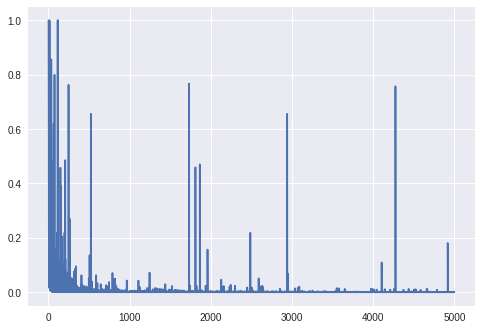

final values:
---------------------------
-0.06| 0.78| 1.00| 0.00|
---------------------------
 0.10| 0.00| 0.78| 0.00|
---------------------------
 0.22| 0.37| 0.54| 0.36|
final policy:
---------------------------
  D  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |


In [7]:
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
#from grid_world import standard_grid, negative_grid
#from iterative_policy_evaluation import print_values, print_policy
#from monte_carlo_es import max_dict

GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')

def print_values(V, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      v = V.get((i,j), 0)
      if v >= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # -ve sign takes up an extra space
    print("")


def print_policy(P, g):
  for i in range(g.width):
    print("---------------------------")
    for j in range(g.height):
      a = P.get((i,j), ' ')
      print("  %s  |" % a, end="")
    print("")

def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

# NOTE: find optimal policy and value function
#       using on-policy first-visit MC

def random_action(a, eps=0.1):
  # choose given a with probability 1 - eps + eps/4
  # choose some other a' != a with probability eps/4
  p = np.random.random()
  # if p < (1 - eps + eps/len(ALL_POSSIBLE_ACTIONS)):
  #   return a
  # else:
  #   tmp = list(ALL_POSSIBLE_ACTIONS)
  #   tmp.remove(a)
  #   return np.random.choice(tmp)
  #
  # this is equivalent to the above
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

def play_game(grid, policy):
  # returns a list of states and corresponding returns
  # in this version we will NOT use "exploring starts" method
  # instead we will explore using an epsilon-soft policy
  s = (2, 0)
  grid.set_state(s)
  a = random_action(policy[s])

  # be aware of the timing
  # each triple is s(t), a(t), r(t)
  # but r(t) results from taking action a(t-1) from s(t-1) and landing in s(t)
  states_actions_rewards = [(s, a, 0)]
  while True:
    r = grid.move(a)
    s = grid.current_state()
    if grid.game_over():
      states_actions_rewards.append((s, None, r))
      break
    else:
      a = random_action(policy[s]) # the next state is stochastic
      states_actions_rewards.append((s, a, r))

  # calculate the returns by working backwards from the terminal state
  G = 0
  states_actions_returns = []
  first = True
  for s, a, r in reversed(states_actions_rewards):
    # the value of the terminal state is 0 by definition
    # we should ignore the first state we encounter
    # and ignore the last G, which is meaningless since it doesn't correspond to any move
    if first:
      first = False
    else:
      states_actions_returns.append((s, a, G))
    G = r + GAMMA*G
  states_actions_returns.reverse() # we want it to be in order of state visited
  return states_actions_returns


if __name__ == '__main__':
  # use the standard grid again (0 for every step) so that we can compare
  # to iterative policy evaluation
  # grid = standard_grid()
  # try the negative grid too, to see if agent will learn to go past the "bad spot"
  # in order to minimize number of steps
  grid = negative_grid(step_cost=-0.1)

  # print rewards
  print("rewards:")
  print_values(grid.rewards, grid)

  # state -> action
  # initialize a random policy
  policy = {}
  for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

  # initialize Q(s,a) and returns
  Q = {}
  returns = {} # dictionary of state -> list of returns we've received
  states = grid.all_states()
  for s in states:
    if s in grid.actions: # not a terminal state
      Q[s] = {}
      for a in ALL_POSSIBLE_ACTIONS:
        Q[s][a] = 0
        returns[(s,a)] = []
    else:
      # terminal state or state we can't otherwise get to
      pass

  # repeat until convergence
  deltas = []
  for t in range(5000):
    if t % 1000 == 0:
      print(t)

    # generate an episode using pi
    biggest_change = 0
    states_actions_returns = play_game(grid, policy)

    # calculate Q(s,a)
    seen_state_action_pairs = set()
    for s, a, G in states_actions_returns:
      # check if we have already seen s
      # called "first-visit" MC policy evaluation
      sa = (s, a)
      if sa not in seen_state_action_pairs:
        old_q = Q[s][a]
        returns[sa].append(G)
        Q[s][a] = np.mean(returns[sa])
        biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
        seen_state_action_pairs.add(sa)
    deltas.append(biggest_change)

    # calculate new policy pi(s) = argmax[a]{ Q(s,a) }
    for s in policy.keys():
      a, _ = max_dict(Q[s])
      policy[s] = a

  plt.plot(deltas)
  plt.show()

  # find the optimal state-value function
  # V(s) = max[a]{ Q(s,a) }
  V = {}
  for s in policy.keys():
    V[s] = max_dict(Q[s])[1]

  print("final values:")
  print_values(V, grid)
  print("final policy:")
  print_policy(policy, grid)
